In [1]:
import glob
import os
import math

import cv2 as cv
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

from utils import config_gpu, img_to_array, load_img
_ = config_gpu()

/home/youjin2/venvs/py3/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## why LAB? 
- more like human eyes
    - L represents luminance (gray-scale)
    - A, B represent color
- model structure
    - input: L
    - output: AB

## load and split data

In [2]:
data_path = '../data/chap9/img/colorize/'
data_lists = glob.glob(os.path.join(data_path, '*.jpg'))

In [3]:
val_n_sample = math.floor(len(data_lists)*0.1)
test_n_sample = math.floor(len(data_lists)*0.1)
train_n_sample = len(data_lists) - val_n_sample - test_n_sample

In [4]:
val_lists = data_lists[:val_n_sample]
test_lists = data_lists[val_n_sample:(val_n_sample+test_n_sample)]
train_lists = data_lists[(val_n_sample+test_n_sample):(train_n_sample+val_n_sample+test_n_sample)]

## preprocess RGB to LAB

In [5]:
img_size = 224

In [6]:
def rgb2lab(rgb):
    assert rgb.dtype == 'uint8'
    
    return cv.cvtColor(rgb, cv.COLOR_RGB2LAB)

def lab2rgb(lab):    
    assert lab.dtype == 'uint8'
    
    return cv.cvtColor(lab, cv.COLOR_LAB2RGB)

def get_lab_from_data_list(data_list):
    
    x_lab = []
    for f in data_list:
        rgb = img_to_array(
            load_img(f, target_size=(img_size, img_size))
        ).astype(np.uint8)
        lab = rgb2lab(rgb)
        x_lab.append(lab)        
        
    return np.stack(x_lab)

def generator_with_preprocessing(data_list, batch_size, shuffle=False):
    
    while True:
        if shuffle:
            np.random.shuffle(data_list)
        for i in range(0, len(data_list), batch_size):
            batch_list = data_list[i:i+batch_size]
            batch_lab = get_lab_from_data_list(batch_list)
            batch_l = batch_lab[:, :, :, 0:1]
            batch_ab = batch_lab[:, :, :, 1:]
            yield (batch_l, batch_ab)

In [7]:
batch_size = 128
epochs = 100

In [8]:
train_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True)
val_gen = generator_with_preprocessing(val_lists, batch_size, shuffle=False)
test_gen = generator_with_preprocessing(test_lists, batch_size, shuffle=False)

In [9]:
train_steps = math.ceil(len(train_lists)/batch_size)
val_steps = math.ceil(len(val_lists)/batch_size)
test_steps = math.ceil(len(test_lists)/batch_size)

## build model

In [10]:
autoencoder = Sequential()

In [11]:
# encoder
# (224, 224, 1) -> (224, 224, 32)
autoencoder.add(
    Conv2D(
        32,
        (3, 3),
        (1, 1),
        activation='relu',
        padding='same',
        input_shape=(224, 224, 1)
    )
)
# (224, 224, 32) -> (112, 112, 64)
autoencoder.add(
    Conv2D(
        64,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
# (112, 112, 64) -> (56, 56, 128)
autoencoder.add(
    Conv2D(
        128,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
# (56, 56, 128) -> (28, 28, 256)
autoencoder.add(
    Conv2D(
        256,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
# decoder
# (28, 28, 256) -> (56, 56, 128)
autoencoder.add(
    Conv2DTranspose(
        128,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
# (56, 56, 128) -> (112, 112, 64)
autoencoder.add(
    Conv2DTranspose(
        64,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
# (112, 112, 64) -> (224, 224, 32)
autoencoder.add(
    Conv2DTranspose(
        32,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
# (224, 224, 32) -> (224, 224, 2)
autoencoder.add(
    Conv2D(
        2,
        (1, 1),
        (1, 1),
        activation='relu',
        padding='same'
    )
)

In [12]:
autoencoder.compile(optimizer='adam', loss='mse')

In [13]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 112, 112, 64)      73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 224, 224, 32)      1

In [14]:
cp_path = '../model/autoencoder_colorize/'
cp_callback = ModelCheckpoint(cp_path, save_weights_only=True, verbose=0)

## takes about 3 hours

In [15]:
# autoencoder.fit_generator(
#     generator=train_gen,
#     steps_per_epoch=train_steps,
#     epochs=epochs,
#     validation_data=val_gen,
#     validation_steps=val_steps,
#     callbacks=[cp_callback]
# )

## load trained model

In [16]:
autoencoder.load_weights(cp_path)

* convert test set's dtype to float32 manually because of following error
___
ValueError: Incompatible type conversion requested to type 'uint8' for variable of type 'float32'
___

In [18]:
pred_rgb = np.zeros(shape=(len(test_lists), 224, 224, 3),
                    dtype='uint8')
true_rgb = np.zeros(shape=(len(test_lists), 224, 224, 3),
                    dtype='uint8')

In [19]:
import time

In [25]:
n_iter = len(list(range(0, len(test_lists), batch_size)))
start_time = time.time()

for idx, i in enumerate(range(0, len(test_lists), batch_size)):
    batch_list = test_lists[i:i+batch_size]
    batch_lab = get_lab_from_data_list(batch_list)
    batch_l = batch_lab[:, :, :, 0:1]
    batch_ab = batch_lab[:, :, :, 1:]
    
    cur_pred = autoencoder.predict(
        batch_l.astype('float32'),
        verbose=0
    )
    
    cur_pred_lab = np.concatenate([batch_l, cur_pred], 3).astype(np.uint8)
    cur_true_lab = np.concatenate([batch_l, batch_ab], 3).astype(np.uint8)
    
    cur_pred_rgb = np.stack([lab2rgb(cur_pred_lab[i, :, :, :])
                             for i in range(len(cur_pred_lab))])
    cur_true_rgb = np.stack([lab2rgb(cur_true_lab[i, :, :, :])
                             for i in range(len(cur_true_lab))])
    
    pred_rgb[i:i+batch_size, :] = cur_pred_rgb
    true_rgb[i:i+batch_size, :] = cur_true_rgb
    
    print('time elapsed: {} ({}/{})'.format(time.time() - start_time, idx, n_iter))

time elapsed: 0.5747191905975342 (0/23)
time elapsed: 1.094393253326416 (1/23)
time elapsed: 1.5969829559326172 (2/23)
time elapsed: 2.108609437942505 (3/23)
time elapsed: 2.6142706871032715 (4/23)
time elapsed: 3.124255418777466 (5/23)
time elapsed: 3.6279852390289307 (6/23)
time elapsed: 4.129773139953613 (7/23)
time elapsed: 4.631502866744995 (8/23)
time elapsed: 5.1330320835113525 (9/23)
time elapsed: 5.644451856613159 (10/23)
time elapsed: 6.157151460647583 (11/23)
time elapsed: 6.724113702774048 (12/23)
time elapsed: 7.272474050521851 (13/23)
time elapsed: 7.832705497741699 (14/23)
time elapsed: 8.38142991065979 (15/23)
time elapsed: 8.927504301071167 (16/23)
time elapsed: 9.483739376068115 (17/23)
time elapsed: 10.04039192199707 (18/23)
time elapsed: 10.605741739273071 (19/23)
time elapsed: 11.152448654174805 (20/23)
time elapsed: 11.700614929199219 (21/23)
time elapsed: 12.531415700912476 (22/23)


In [31]:
(((pred_rgb - true_rgb)**2).mean())

72.96382553557

In [39]:
def draw_figure(pred, true, i):
    
    titles = ['Predict RGB', 'True RGB']
    fig, ax_arr = plt.subplots(1, 2)
    for idx, img in enumerate([pred[i], true[i]]):
        ax = ax_arr[idx]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(titles[idx])
        
    fig.subplots_adjust(right=2, top=1)

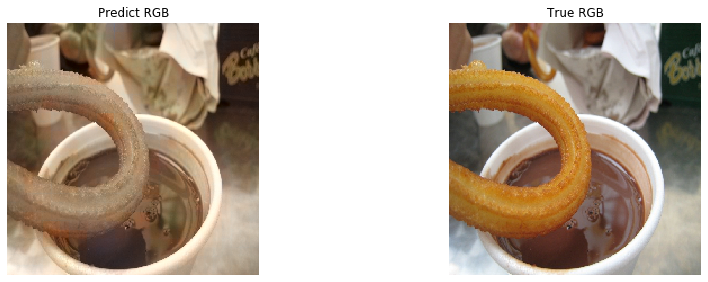

In [99]:
draw_figure(pred_rgb, true_rgb, -310)

## further readings
- one can make more realistic colorized images by binaryzing AB space and solve it as a classification problem
    - - https://richzhang.github.io/colorization/resources/colorful_eccv2016.pdf
    - see: https://richzhang.github.io/colorization
- use GAN
    - see chapter 12